# Notebook Setup

## New Metrics Switch

In [1]:
# Boolean flag to signal whether it's necessary to load all of hte results
# and calculate new performance statistics.
# This takes several hours.
CALCULATE_NEW_METRICS = False

# If we calculate new performance statistics, they are saved in this file.
# If we do not calculate new performance statistics, old ones are loaded
# from this file.
time_split_stats_filename = 'results/time_split_statistics.pkl'

## Imports

In [2]:
import glob
import numpy as np
from pathlib import Path
import pickle as pkl

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

# The neuralhydroloy repository must exist in the current working directory.
from neuralhydrology.evaluation import metrics

## Metrics List

In [3]:
# Returns a list of all available performance metrics in NeuralHydrology
metrics_list = metrics.get_available_metrics()
print('The available metrics are:')
metrics_list


The available metrics are:


['NSE',
 'MSE',
 'RMSE',
 'KGE',
 'Alpha-NSE',
 'Pearson-r',
 'Beta-KGE',
 'Beta-NSE',
 'FHV',
 'FMS',
 'FLV',
 'Peak-Timing']

In [4]:
# Remove any metrics that you don't care about. 
# Feel free to change this.
metrics_list.remove('MSE')
metrics_list.remove('RMSE')
metrics_list.remove('FHV')
metrics_list.remove('FMS')
metrics_list.remove('FLV')
metrics_list.remove('Beta-KGE')

print('The metrics that we are going to calculate are:')
metrics_list

The metrics that we are going to calculate are:


['NSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-KGE', 'Beta-NSE', 'Peak-Timing']

## Basins

In [5]:
basin_file = '531_basin_list.txt'
with Path(basin_file).open('r') as fp:
    basins = sorted(basin.strip() for basin in fp if basin.strip())
print(f"There are {len(basins)} basins.")

There are 531 basins.


## Paths

In [6]:
# Paths to results from different models. 
# Note that these must match what is in the config files.
autoregression_dir = 'runs/time_split/autoregression'
assimilation_dir = 'runs/time_split/assimilation'
simulation_dir = 'runs/time_split/simulation'

In [7]:
# Get paths to all simulation results.
simulation_run_dirs = glob.glob(simulation_dir + '/simulation_*')
for i, run_dir in enumerate(simulation_run_dirs):
    simulation_run_dirs[i] = run_dir.split('/')[-1]
print(f"There are {len(simulation_run_dirs)} simulation runs.")

There are 1 simulation runs.


In [8]:
# Get paths to all assimilation results.
assimilation_run_dirs = glob.glob(assimilation_dir + '/**')
for i, run_dir in enumerate(assimilation_run_dirs):
    assimilation_run_dirs[i] = run_dir.split('/')[-1]
print(f"There are {len(assimilation_run_dirs)} assimilation runs.")

There are 25 assimilation runs.


In [9]:
# Get paths to all autoregression results.
autoregression_run_dirs = glob.glob(autoregression_dir + '/**')
for i, run_dir in enumerate(autoregression_run_dirs):
    autoregression_run_dirs[i] = run_dir.split('/')[-1]
print(f"There are {len(autoregression_run_dirs)} autoregression runs.")

There are 150 autoregression runs.


# Experiment Definition

## Infer Experiment Parameters

In [10]:
# Infer the "dimensions" of the experiment. This informatoin is available from the
# directory names.
lead_times = set()
train_holdout_fractions = set()
test_holdout_fractions = set()
ensembles = set()


for run in autoregression_run_dirs:
    if 'train_holdout' in run:
        train_holdout_fractions.add(float(run.split('train_holdout_')[-1].split('_')[0]))    
        test_holdout_fractions.add(float(run.split('test_holdout_')[-1].split('_')[0]))    
    lead_times.add(int(run.split('lead_')[-1].split('_')[0]))  
    ensembles.add(int(run.split('seed_')[-1].split('_')[0]))

train_holdout_fractions = sorted(list(train_holdout_fractions))
test_holdout_fractions = sorted(list(test_holdout_fractions))
lead_times = sorted(list(lead_times))
ensembles = sorted(list(ensembles))

## Initialize Storage

In [11]:
# Indexes over the experiment "dimensions" for AR and DA.
ar_index = pd.MultiIndex.from_product((train_holdout_fractions, test_holdout_fractions, lead_times, ensembles))
da_index = pd.MultiIndex.from_product((train_holdout_fractions, lead_times, ensembles))

# Create mappings from metric names to data frames of metric values.
autoregression_statistics = {}
assimilation_statistics = {}
simulation_statistics = {}
for metric in metrics_list:
    autoregression_statistics[metric] = pd.DataFrame(index=basins, columns=ar_index, dtype=np.float64)
    assimilation_statistics[metric] = pd.DataFrame(index=basins, columns=da_index, dtype=np.float64)
    simulation_statistics[metric] = pd.DataFrame(index=basins, columns=ensembles, dtype=np.float64)

## Load Obs Data

In [12]:
# The observation data set from experiments with non-zero holdout fractions are incomplete. 
# It is necessary to use the observation record with no holdout to calculate performance 
# statistics. Get this from one of the simulation directories.
# All experiments use the same train/test split, so this time period works for everything.
with open(Path(simulation_dir) / simulation_run_dirs[0] / 'test/model_epoch030/test_results.p', 'rb') as f:
    data_xr = pkl.load(f)

# Calculate Metrics

## Simulation

In [13]:
if CALCULATE_NEW_METRICS:
    for run in simulation_run_dirs:
        ensemble = int(run.split('seed_')[-1].split('_')[0])

        with open(simulation_dir + '/' + run + '/test/model_epoch030/test_results.p', 'rb') as f:
            run_data = pkl.load(f)

        for basin in tqdm(basins):

            sim = run_data[basin]['1D']['xr'].stack(datetime=['date', 'time_step'])['QObs(mm/d)_sim']
            sim['datetime'] = sim.coords['date']# + sim.coords['time_step']
            obs = data_xr[basin]['1D']['xr']['QObs(mm/d)_obs'].stack(datetime=['date', 'time_step'])
            obs['datetime'] = obs.coords['date']# + obs.coords['time_step']
            basin_metrics = metrics.calculate_metrics(obs=obs, sim=sim, metrics=metrics_list)

            for metric in metrics_list:
                simulation_statistics[metric].loc[basin, ensemble] = basin_metrics[metric]

In [14]:
simulation_statistics['NSE'].median()

0   NaN
dtype: float64

## Assimilation

In [15]:
if CALCULATE_NEW_METRICS:
    for run in tqdm(assimilation_run_dirs):
        hf = float(run.split('holdout_')[-1].split('_')[0])   
        lead_time = int(run.split('lead_')[-1].split('_')[0])
        ensemble = int(run.split('seed_')[-1].split('_')[0])

        with open(assimilation_dir + '/' + run + '/test/model_epoch030/test_results_data_assimilation.p', 'rb') as f:
            run_data = pkl.load(f)

        for basin in basins:
            sim = run_data[basin]['1D']['xr'].stack(datetime=['date', 'time_step'])['QObs(mm/d)_sim']
            sim['datetime'] = sim.coords['date']# + sim.coords['time_step']
            obs = data_xr[basin]['1D']['xr']['QObs(mm/d)_obs'].stack(datetime=['date', 'time_step'])
            obs['datetime'] = obs.coords['date']# + obs.coords['time_step']
            basin_metrics = metrics.calculate_metrics(obs=obs, sim=sim, metrics=metrics_list)

            for metric in metrics_list:
                assimilation_statistics[metric].loc[basin, (hf, lead_time, ensemble)] = basin_metrics[metric]

In [16]:
assimilation_statistics['NSE'].median()

0.00  1   0   NaN
      2   0   NaN
      4   0   NaN
      8   0   NaN
      10  0   NaN
0.25  1   0   NaN
      2   0   NaN
      4   0   NaN
      8   0   NaN
      10  0   NaN
0.50  1   0   NaN
      2   0   NaN
      4   0   NaN
      8   0   NaN
      10  0   NaN
0.75  1   0   NaN
      2   0   NaN
      4   0   NaN
      8   0   NaN
      10  0   NaN
1.00  1   0   NaN
      2   0   NaN
      4   0   NaN
      8   0   NaN
      10  0   NaN
dtype: float64

## Autoregression

In [17]:
if CALCULATE_NEW_METRICS:
    for run in tqdm(autoregression_run_dirs):
        if 'train_holdout' not in run:
            continue
        train_hf = float(run.split('train_holdout_')[-1].split('_')[0])   
        test_hf = float(run.split('test_holdout_')[-1].split('_')[0])   
        lead_time = int(run.split('lead_')[-1].split('_')[0])
        ensemble = int(run.split('seed_')[-1].split('_')[0])
        
        with open(autoregression_dir + '/' + run + '/test/model_epoch030/test_results.p', 'rb') as f:
            run_data = pkl.load(f)

        for basin in basins:
            sim = run_data[basin]['1D']['xr'].stack(datetime=['date', 'time_step'])['QObs(mm/d)_sim']
            sim['datetime'] = sim.coords['date']# + sim.coords['time_step']
            obs = data_xr[basin]['1D']['xr']['QObs(mm/d)_obs'].stack(datetime=['date', 'time_step'])
            obs['datetime'] = obs.coords['date']# + obs.coords['time_step']
            basin_metrics = metrics.calculate_metrics(obs=obs, sim=sim, metrics=metrics_list)

            for metric in metrics_list:
                autoregression_statistics[metric].loc[basin, (train_hf, test_hf, lead_time, ensemble)] = basin_metrics[metric]

In [18]:
autoregression_statistics['NSE'].median().dropna()

Series([], dtype: float64)

## Save & Load Precaculated Metrics

In [19]:
# If we calculated new metrics, save these over any old ones that might exist.
if CALCULATE_NEW_METRICS:
    with open(time_split_stats_filename, 'wb') as f:
        pkl.dump([
            simulation_statistics,
            autoregression_statistics,
            assimilation_statistics
        ], f)

In [20]:
# Load in the saved metrics. 
# Even if we just calcuated them, might as well make sure the file works.
with open(time_split_stats_filename, 'rb') as f:
    simulation_statistics, autoregression_statistics, assimilation_statistics = pkl.load(f)

# Figures

## Figure 1

Median NSE scores of AR models trained and tested with different fractions of lagged streamflow data withheld. The two subplots
show the same results, but organized by the amount of lagged streamflow data withheld during training vs. during testing.

In [21]:
# import matplotlib
# matplotlib.use('TkAgg')

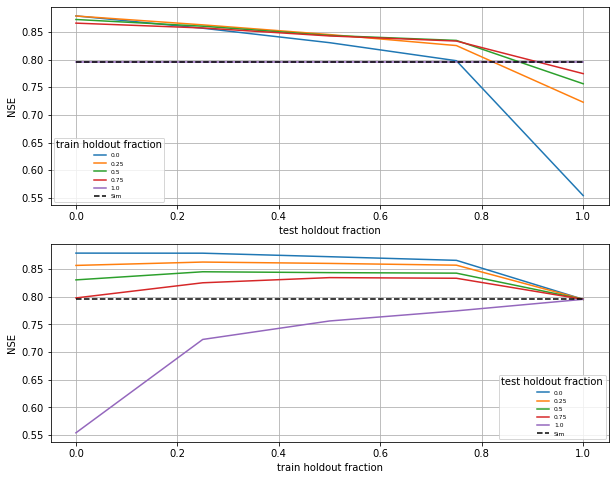

In [22]:
# By test holdout
lead_time = 1
metric = 'NSE'

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for hf in test_holdout_fractions:
    plotdata = autoregression_statistics[metric].median().loc[hf] 
    plotdata = plotdata.loc[(slice(None), lead_time, 0)]
    axes[0].plot(test_holdout_fractions, plotdata.values, label=hf)
axes[0].plot([0,1], [simulation_statistics[metric].median().values[0], simulation_statistics[metric].median().values[0]], 'k--', label='Sim')
axes[0].set_xlabel('test holdout fraction')
axes[0].legend(title="train holdout fraction", prop={'size': 6})
axes[0].set_ylabel(metric)
axes[0].grid()

for hf in train_holdout_fractions:
    plotdata = autoregression_statistics[metric].median().loc[(slice(None), hf)] 
    plotdata = plotdata.loc[(slice(None), lead_time, 0)]
    axes[1].plot(test_holdout_fractions, plotdata.values, label=hf)
axes[1].plot([0,1], [simulation_statistics[metric].median().values[0], simulation_statistics[metric].median().values[0]], 'k--', label='Sim')
axes[1].set_xlabel('train holdout fraction')
axes[1].legend(title="test holdout fraction", prop={'size': 6})
axes[1].set_ylabel(metric)
axes[1].grid()

plot_file_name = f"./results/plots/figure1_ar_holdout.png"
plt.savefig(plot_file_name)


## Figure 2

Comparison of per-basin NSEs with an observation lag of one day and no missing streamflow input data: (left) autoregression
trained with no holdout data vs. variational assimilation and (right) autoregression with vs. without 50% of lagged streamflow data withheld
during training

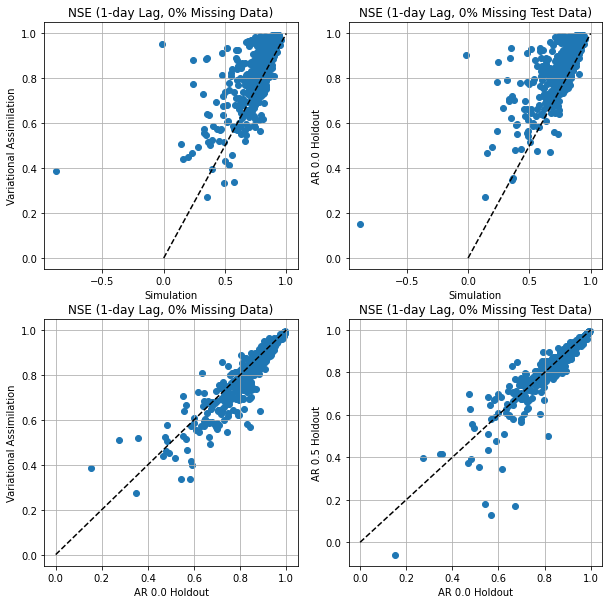

In [23]:
metric = 'NSE'
fig, axes = plt.subplots(2, 2, figsize=(10,10))

xdata = simulation_statistics[metric][0]
ydata = assimilation_statistics[metric][(0.0, 1, 0)]
axes[0,0].scatter(xdata, ydata)
axes[0,0].plot([0, 1], [0, 1], 'k--')
axes[0,0].set_xlabel('Simulation')
axes[0,0].set_ylabel('Variational Assimilation')
axes[0,0].set_title('NSE (1-day Lag, 0% Missing Data)')
axes[0,0].grid()

xdata = simulation_statistics[metric][0]
ydata = autoregression_statistics[metric][(0.0, 0.0, 1, 0)]
axes[0,1].scatter(xdata, ydata)
axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].set_xlabel('Simulation')
axes[0,1].set_ylabel('AR 0.0 Holdout')
axes[0,1].set_title('NSE (1-day Lag, 0% Missing Test Data)')
axes[0,1].grid()

xdata = autoregression_statistics[metric][(0.0, 0.0, 1, 0)]
ydata = assimilation_statistics[metric][(0.0, 1, 0)]
axes[1,0].scatter(xdata, ydata)
axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_xlabel('AR 0.0 Holdout')
axes[1,0].set_ylabel('Variational Assimilation')
axes[1,0].set_title('NSE (1-day Lag, 0% Missing Data)')
axes[1,0].grid()

xdata = autoregression_statistics[metric][(0.0, 0.0, 1, 0)]
ydata = autoregression_statistics[metric][(0.5, 0.0, 1, 0)]
axes[1,1].scatter(xdata, ydata)
axes[1,1].plot([0, 1], [0, 1], 'k--')
axes[1,1].set_xlabel('AR 0.0 Holdout')
axes[1,1].set_ylabel('AR 0.5 Holdout')
axes[1,1].set_title('NSE (1-day Lag, 0% Missing Test Data)')
axes[1,1].grid()

plot_file_name = f"./results/plots/figure2_scatterplot.png"
plt.savefig(plot_file_name)

## Figure 3 & Appendix G

Median NSE over 531 basins of four models (simulation, autoregression trained with and without holdout data, and data assimilation) as a function of lag time in days and fraction of missing lagged streamflow data in the test period.

In [24]:
simulation_statistics[metric]

,0
01022500,0.858931
01031500,0.896980
01047000,0.859059
01052500,0.871757
01054200,0.772108
...,...
14309500,0.885777
14316700,0.911744
14325000,0.928631
14362250,0.906987


/home/gsnearing/anaconda3/envs/neuralhydrology/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


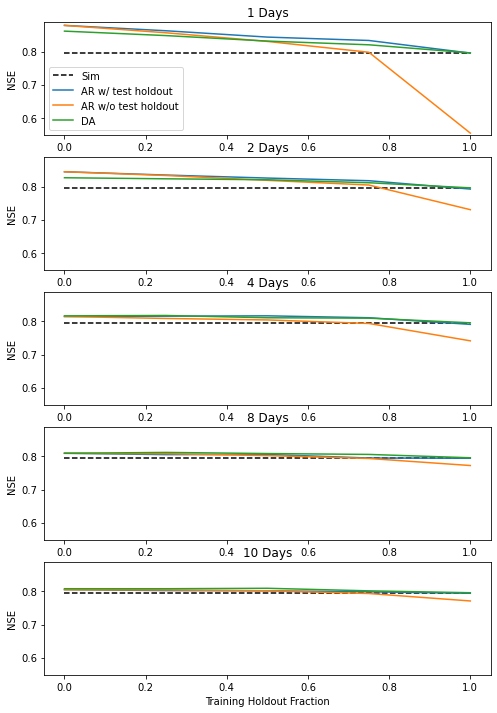

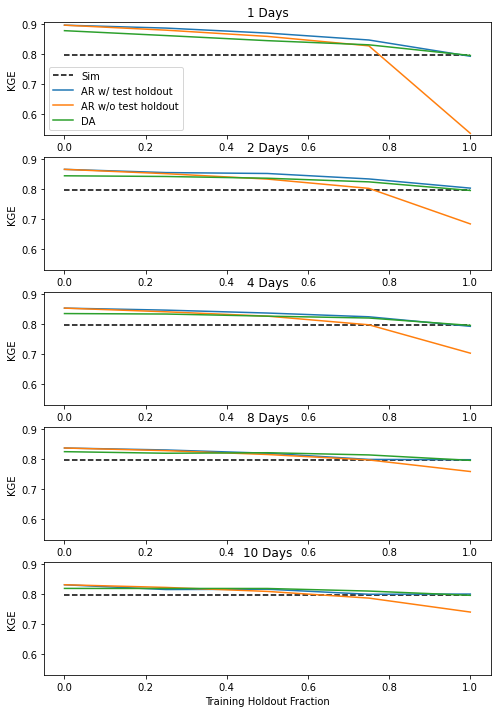

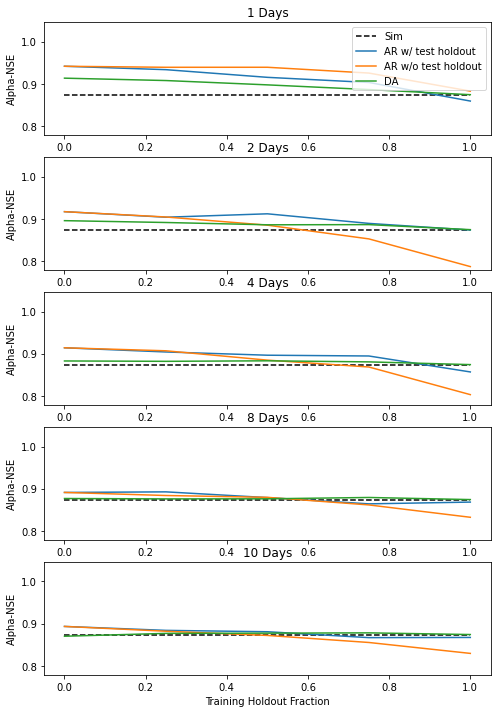

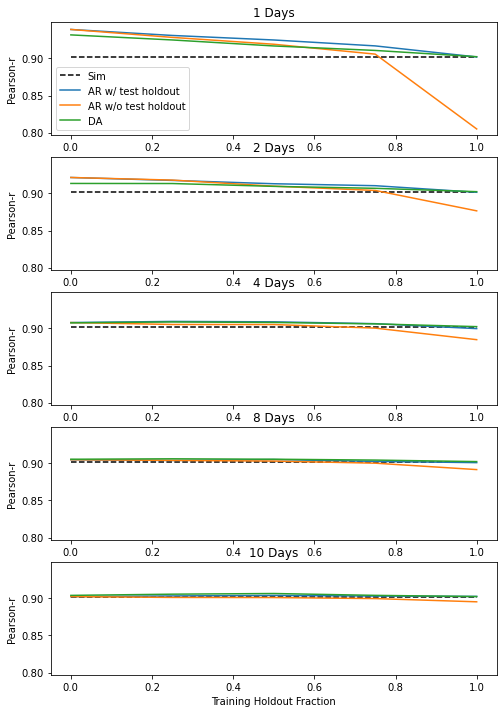

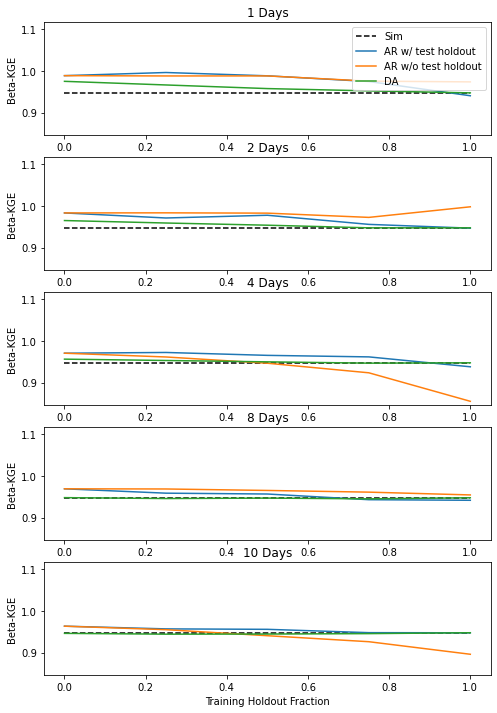

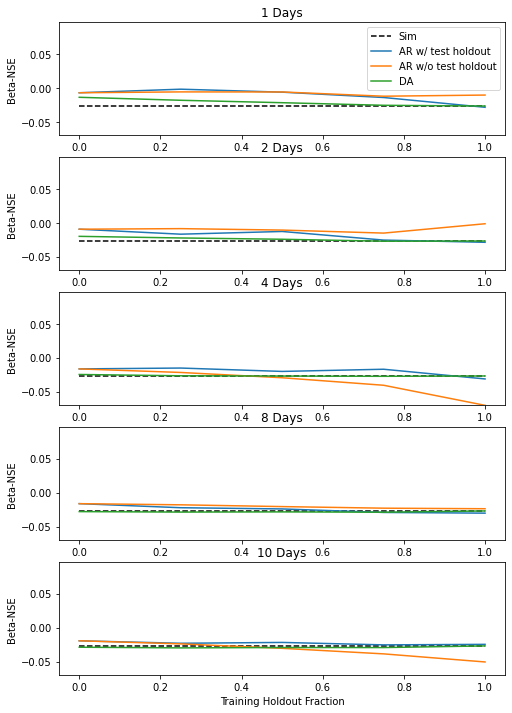

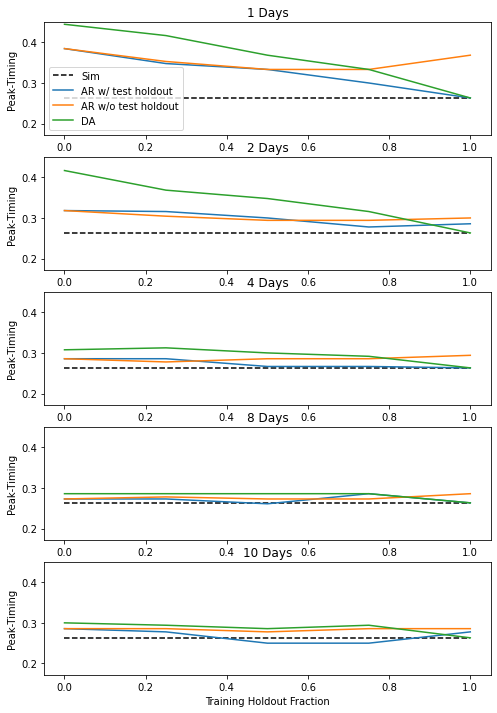

In [33]:
for metric in metrics_list:

    ar_plotdata_hf = pd.DataFrame(index=lead_times, columns=train_holdout_fractions)
    for lt in lead_times:
        for hf in train_holdout_fractions:
            ar_plotdata_hf.loc[lt, hf] = autoregression_statistics[metric].median().loc[(hf, hf, lt, 0)]

    ar_plotdata_0 = pd.DataFrame(index=lead_times, columns=train_holdout_fractions)
    for lt in lead_times:
        for hf in train_holdout_fractions:
            ar_plotdata_0.loc[lt, hf] = autoregression_statistics[metric].median().loc[(0.0, hf, lt, 0)]

    da_plotdata = pd.DataFrame(index=lead_times, columns=train_holdout_fractions)
    for lt in lead_times:
        for hf in train_holdout_fractions:
            da_plotdata.loc[lt, hf] = assimilation_statistics[metric].median().loc[(hf, lt, 0)]
    
    ymin = np.min([simulation_statistics[metric].values[0], ar_plotdata_hf.min().min(), ar_plotdata_0.min().min(), da_plotdata.min().min()]) * 0.99
    ymax = np.max([simulation_statistics[metric].values[0], ar_plotdata_hf.max().max(), ar_plotdata_0.max().max(), da_plotdata.max().max()]) * 1.01

    fig, axes = plt.subplots(5, 1, figsize=(8, 12))
    for i, lead_time in enumerate(lead_times):
        axes.flatten()[i].plot([simulation_statistics[metric].median(), simulation_statistics[metric].median()], 'k--', label='Sim')
        axes.flatten()[i].plot(ar_plotdata_hf.loc[lead_time], label='AR w/ test holdout')
        axes.flatten()[i].plot(ar_plotdata_0.loc[lead_time], label='AR w/o test holdout')
        axes.flatten()[i].plot(da_plotdata.loc[lead_time], label='DA')
        if i == 0: axes.flatten()[i].legend()
        axes.flatten()[i].set_xlabel('Training Holdout Fraction')
        axes.flatten()[i].set_ylabel(metric)
        axes.flatten()[i].set_ylim([ymin, ymax])
        axes.flatten()[i].set_title(f'{lead_time} Days')
        
    plot_file_name = f"./results/plots/{metric}_lead_times_plots.png"
    plt.savefig(plot_file_name)

# Tables

## Table 2

Median NSE scores of AR models trained and tested with different fractions of lagged streamflow data withheld. The two subplots
show the same results, but organized by the amount of lagged streamflow data withheld during training vs. during testing

In [26]:
# TODO: Allow this to work with ensembles instead of just pulling the 0th member.
models_list = ['Simulation', 'AR 0.0 holdout', 'AR 0.5 holdout', 'Assimilation']
table_df = pd.DataFrame(index=metrics_list, columns=models_list)
for metric in metrics_list:
    table_df.loc[metric, 'Simulation'] = simulation_statistics[metric].median().values[0]
    table_df.loc[metric, 'AR 0.0 holdout'] = autoregression_statistics[metric].median().loc[(0.0, 0.0, 1, 0)]
    table_df.loc[metric, 'AR 0.5 holdout'] = autoregression_statistics[metric].median().loc[(0.5, 0.0, 1, 0)]
    table_df.loc[metric, 'Assimilation'] = assimilation_statistics[metric].median().loc[(0.0, 1, 0)]
table_df

,Simulation,AR 0.0 holdout,AR 0.5 holdout,Assimilation
NSE,0.796015,0.878965,0.872467,0.86165
KGE,0.795093,0.895984,0.896291,0.877679
Alpha-NSE,0.874312,0.941669,0.945333,0.913461
Pearson-r,0.902341,0.938994,0.937198,0.931684
Beta-KGE,0.947575,0.988823,0.996909,0.975229
Beta-NSE,-0.026813,-0.007236,-0.002175,-0.013917
Peak-Timing,0.263158,0.384615,0.368421,0.444444


In [27]:
# Save to file in latex format.
table_filename = 'results/tables/zero_lag_zero_holdout_metrics_table.txt'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
with open(table_filename, 'wt') as f:
    f.write(table_df.to_latex())